# CP 4 Aprendizaje de Máquinas
---

## Regresión Logística

En esta clase práctica, seguiremos usando el dataset de _Rotten Tomatoes_ para clasificar críticas positivas y negativas. Como en las clases anteriores, extraemos el contenido de los archivos.

In [46]:
from pathlib import Path

path_p = Path("txt_sentoken/pos")
path_n = Path("txt_sentoken/neg")

ds_p = list(path_p.iterdir())     # directorio donde están las críticas positivas
ds_n = list(path_n.iterdir())     # directorio donde están las críticas negativas

def convert_file_to_text(file_path: Path) -> str:
    with open(file_path) as f:
        return ''.join(f.readlines())
    
texts_p = [convert_file_to_text(file) for file in ds_p]    # Lista de críticas positivas
texts_n = [convert_file_to_text(file) for file in ds_n]    # Lista de críticas negativas

### Ejercicio 1: Regresión Logística aplicado al dataset de _Rotten Tomatoes_

In [47]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer()
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

y = [1]*1000 + [0]*1000

In [48]:
X.shape

(2000, 39659)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.81

### Ejercicio 2: Aplicando la Matriz de Confusión

In [52]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

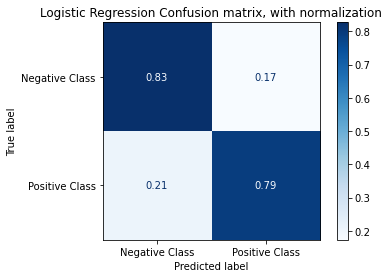

In [53]:
disp = plot_confusion_matrix(lr_model, X_test, y_test,
                             display_labels=['Negative Class', 'Positive Class'],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Ejercicio 3: Probando la clasificación de un texto en específico

In [54]:
lr_model.classes_

array([0, 1])

In [55]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.47988569, 0.52011431]])

### Ejercicio 4: Generación de Bigramas 

In [56]:
cv = CountVectorizer(ngram_range=(2,2))
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

In [57]:
X.shape

(2000, 499250)

### Ejercicio 5: Ideas para Mejorar: Utilizar Bigramas con Regresión Logística

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

In [59]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.7983333333333333

### Ejercicio 6: Vizualizando los Bigramas más Importantes

In [60]:
import numpy as np
import seaborn as sns

In [61]:
feature_importance = lr_model.coef_[0]
sorted_idx = np.argsort(feature_importance)

In [62]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['he is', 'the best', 'and it', 'is very', 'is an', 'to the', 'as the', 'is also', 'one of', 'it was']


In [63]:
top_10_pos_importance = feature_importance[sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_importance)

[0.36417862 0.35523834 0.32854802 0.28953667 0.28595486 0.27120542
 0.26483967 0.25717921 0.25058294 0.23642598]


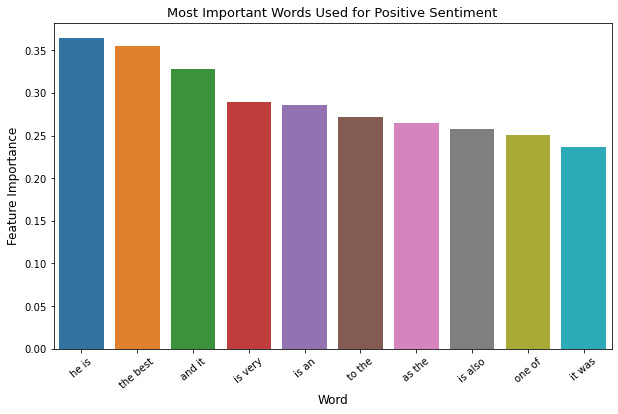

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_pos_w, y=top_10_pos_importance)
plt.title("Most Important Words Used for Positive Sentiment", fontsize=13)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize = 12);

In [65]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['have been', 'the worst', 'the only', 'should have', 'to be', 'supposed to', 'at least', 'but the', 'tries to', 'to make']


In [66]:
top_10_neg_importance = feature_importance[sorted_idx[:10]]
print(top_10_neg_importance)

[-0.46827974 -0.44540836 -0.3955938  -0.38113043 -0.37259572 -0.3339515
 -0.32621474 -0.28195266 -0.27158064 -0.2540254 ]


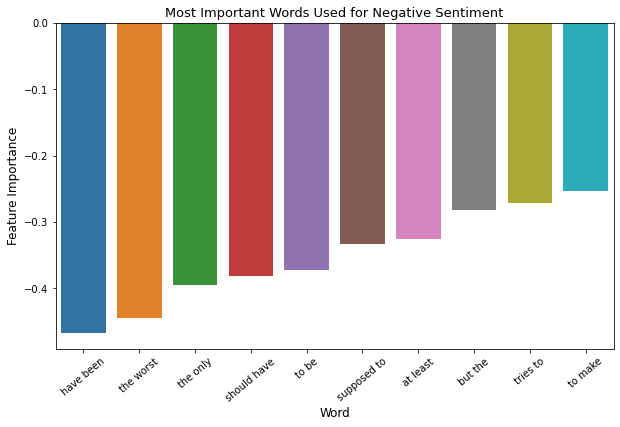

In [67]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_neg_w, y=top_10_neg_importance)
plt.title("Most Important Words Used for Negative Sentiment", fontsize = 13)
x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [68]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.55097805, 0.44902195]])

### Ejercicio 7: Ideas Para Mejorar: Eliminar Ruido

In [69]:
cv = CountVectorizer(min_df=10, max_df=0.95, binary=True, ngram_range=(1,2))
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()
X.shape

(2000, 21963)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

In [71]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.885

### Ejercicio 8: Ideas para Mejorar: Disminuir el umbral de corte de probabilidad

In [72]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [73]:
pred_proba_df = pd.DataFrame(lr_model.predict_proba(X_test))
threshold_list = [0.3, 0.4, 0.45, 0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = round(accuracy_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Accuracy: {}'.format(test_accuracy))


******** For i = 0.3 ******
Accuracy: 0.853

******** For i = 0.4 ******
Accuracy: 0.878

******** For i = 0.45 ******
Accuracy: 0.885

******** For i = 0.5 ******
Accuracy: 0.885
